<a href="https://colab.research.google.com/github/namoshi/dl_intro/blob/master/lab_tutorial1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Convolutional Neural Network


This is an example of classification of mnist using Convolutional Neural Network.

※If you want to perform learning, create a source file.



Import of required library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import Tensor
import torch.nn.functional as F
print(torch.__version__)
if torch.cuda.is_available():
    print('cuda is available')
else:
    print('cuda is not avaibalbe')

1.0.0
cuda is available


Fixed seed value for random numbers.

The initial value of the weight is determined by random numbers. By fixing the seed value of the random number, the initial value of the weight is fixed to prevent different results depending on the initial value.

In [2]:
torch.cuda.manual_seed_all(100100)
torch.manual_seed(100100)
np.random.seed(100100)

Reading dataset.

Image data is stored in x_train and x_test, and labels are stored in y_train and y_test.

This part should be rewritten as appropriate depending on the data set you use.

The input image to the model should have the shape of $(N, C, H, W)$.

$N:$ number of data

$C:$ number of channnel

$H:$ height

$W:$ width

In [3]:
mnist_train = dsets.MNIST(".", download=True, train=True)
x_train = []
y_train = []
x_test = []
y_test = []

mnist_test = dsets.MNIST(".", download=True, train=False)



for i in range(len(mnist_train)):
	x_train.append(np.array(mnist_train[i][0]))
	y_train.append(mnist_train[i][1])

for i in range(len(mnist_test)):
	x_test.append(np.array(mnist_test[i][0]))
	y_test.append(mnist_test[i][1])

#Change shape to (N, C, H, W) by reshape.
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = x_train.reshape(len(mnist_train), 1, 28, 28)
x_train = x_train / 255.0

x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = x_test.reshape(len(mnist_test), 1, 28, 28)
x_test = x_test / 255.0


datasize = len(y_train)
datasize_test = len(y_test)

0it [00:00, ?it/s]

9920512it [00:02, 3444714.19it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 54046.29it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:04, 395705.24it/s]                             


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz


0it [00:00, ?it/s]

8192it [00:00, 18000.68it/s]            


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Define the model structure.

The computation within the convolution layers is regarded as a filtering process of the input image as
\begin{align}
f_{p,q}^{(c)}=h(\sum^{convy-1}_{r=0}\sum^{convx-1}_{s=0}w^{(c)}_{r,s}f^{(c-1)}_{p+r, q+s}+b^{(c)}) \; ,
\end{align}

where $w^{(c)}_{r,s}$ is the weight of the neuron indexed as $(r,s)$ in the $c$-th convolution layer and $b^{(c)}$ is the bias of the $c$-th convolution layer. 

The size of the convolution filter is given as $convx \times convy$. The activation function of each neuron is denoted as $h$. 

Usually, pooling layers are added after the convolution layers. The pooling layer performs downsampling for reducing computational costs and enhancing against micro position changes. 

Fully-connected layers like multi layer perceptron is connected to the convolution layers which is used to construct the classifier. 

In this example, a model of the following structure is defined.


---

convolution layer1:(filtersize:3*3, channel:32)

convolution layer2:(filtersize:3*3, channel:32)

full connected:(128)


---



In [4]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Network()
net.cuda()

Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Definition of loss function.

The cross entropy loss is defined as the following equation.


\begin{align}
E = \sum_n^N {\boldsymbol t}_n^Tlog(S({\boldsymbol y}_n)) \; 
\end{align}

$S(\cdot)$ is an activation function of the output layer.

${\boldsymbol t_n}$ is a label and ${\boldsymbol y_n}$ is the output of the network.

In multiclass classification, the softmax function is generally used for the activation function of the output layer.

In [6]:
softmax_cross_entropy = nn.CrossEntropyLoss()

Definition of optimizer. 

In the example, the stochastic gradient descent method with momentum (SGD with momentum) is used.

$\mu$ is a learning rate and $\eta$ is a momentum parameter.

\begin{align}
{\boldsymbol w}^{(t+1)} &\leftarrow {\boldsymbol w}^{(t)} + \Delta  {\boldsymbol w}^{(t)} \\
 \Delta  {\boldsymbol w}^{(t)} &= \mu \Delta {\boldsymbol w}^{(t - 1)} - (1-\mu) \eta {\boldsymbol g}^{(t)} \\
 {\boldsymbol g}^{(t)} &= \nabla E({\boldsymbol w}^{(t)})
 \end{align}
 
In addition, regularization terms such as weight decay may be added as necessary to prevent over-learning.

In [7]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

Input data into the model for each mini-batch and perform parameter update.

(1)


In [8]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]

#define batch-size and epoch.
epoch=100
batchsize=100


for epoch in range(1, epoch+1):
	print('epoch', epoch)
	perm = np.random.permutation(datasize)
	for i in range(0, datasize, batchsize):
    #Create mini-batch.
		x_batch = x_train[perm[i:i+batchsize]]
		y_batch = y_train[perm[i:i+batchsize]]
    
    #Convert a numpy array to a tensor to do gradient calculations.
		x_batch = torch.from_numpy(x_batch).float().cuda()
		y_batch = torch.from_numpy(y_batch).long().cuda()
    
    #Initialize the stored gradient.
		optimizer.zero_grad()
    
    #Get the model output for the input mini-batch.
		y = net(x_batch)
    
    #Calculate loss from the output of the model. At this time, the activation function of the output layer is also reflected in the calculation.
		loss = softmax_cross_entropy(y, y_batch)  
    
    #From loss, calculate the gradient of each parameter.
		loss.backward()               
    
    #Each parameter is updated from the calculated gradient.
		optimizer.step()



	sum_score = 0
	sum_loss = 0
  
  #Evaluate the model with train data.
	for i in range(0, datasize, batchsize):
		x_batch = x_train[i:i+batchsize]
		y_batch = y_train[i:i+batchsize]
		x_batch = torch.from_numpy(x_batch).float().cuda()
		y_batch = torch.from_numpy(y_batch).long().cuda()
		y = net(x_batch)
		loss = softmax_cross_entropy(y, y_batch)
		sum_loss += float(loss.cpu().data.item()) * batchsize
		_, predict = y.max(1)
		sum_score += predict.eq(y_batch).sum().item()
	print("\ttrain  mean loss={}, accuracy={}".format(sum_loss / datasize, sum_score / datasize))
	train_loss.append(sum_loss / datasize)
	train_acc.append(sum_score / datasize)


	sum_score = 0
	sum_loss = 0

  
  #Evaluate the model with test data.
	for i in range(0, datasize_test, batchsize):
		x_batch = x_test[i:i+batchsize]
		y_batch = y_test[i:i+batchsize]
		x_batch = torch.from_numpy(x_batch).float().cuda()
		y_batch = torch.from_numpy(y_batch).long().cuda()
		y = net(x_batch)
		loss = softmax_cross_entropy(y, y_batch)
		sum_loss += float(loss.cpu().data.item()) * batchsize
		_, predict = y.max(1)
		sum_score += predict.eq(y_batch).sum().item()
	print("\ttest  mean loss={}, accuracy={}".format(sum_loss / datasize_test, sum_score / datasize_test))
	test_loss.append(sum_loss / datasize_test)
	test_acc.append(sum_score / datasize_test)


epoch 1
train  mean loss=0.1351327899408837, accuracy=0.95935
test  mean loss=0.1259777995897457, accuracy=0.9619
epoch 2
train  mean loss=0.09063731806507955, accuracy=0.97275
test  mean loss=0.08213552559958771, accuracy=0.9733
epoch 3
train  mean loss=0.07233886431902647, accuracy=0.9788333333333333
test  mean loss=0.06350874728988856, accuracy=0.9804
epoch 4
train  mean loss=0.07524648154464861, accuracy=0.9783666666666667
test  mean loss=0.07075838819611818, accuracy=0.9772
epoch 5
train  mean loss=0.0696935814494888, accuracy=0.9799
test  mean loss=0.06751868469174951, accuracy=0.98
epoch 6
train  mean loss=0.06491393074781324, accuracy=0.98205
test  mean loss=0.06501803285209462, accuracy=0.9789
epoch 7
train  mean loss=0.07943253310397268, accuracy=0.9761666666666666
test  mean loss=0.07588617905741557, accuracy=0.9765
epoch 8
train  mean loss=0.061922105875176686, accuracy=0.9831166666666666
test  mean loss=0.06028017420787364, accuracy=0.9817
epoch 9
train  mean loss=0.058418

Draw a graph of training curve (loss).

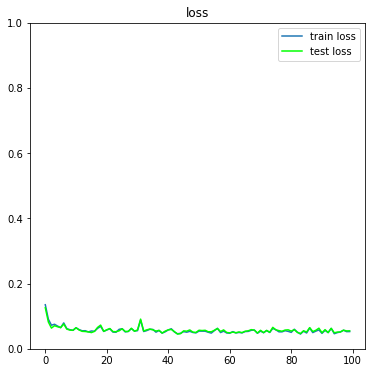

In [9]:
plt.figure(figsize=(6,6))

plt.ylim(0,1.0)
plt.plot(range(epoch), train_loss)
plt.plot(range(epoch), test_loss, c='#00ff00')
plt.legend(['train loss', 'test loss'])
plt.title('loss')
plt.show()

Draw the graph of training curve (accuracy).

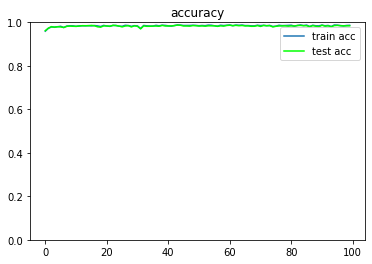

In [10]:
plt.plot(range(epoch), train_acc)
plt.plot(range(epoch), test_acc, c='#00ff00')
plt.ylim(0,1.0)
plt.legend(['train acc', 'test acc'])
plt.title('accuracy')
plt.show()

The result is as follows.

※lr (learning rate) = 0.01, weightdecay parameter = 0.005

In [11]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Network()
net.cuda()


optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)

In [12]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Network()
net.cuda()


optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

In [13]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Network()
net.cuda()


optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

In [14]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]
weight_num = 10




#define batch-size and epoch.
epoch=100
batchsize=100

train_weight = np.zeros((epoch, weight_num))
rum_num = np.array([0,0,0,50,50,50,100,100,100,127])
perm_num = np.array([0, 500, 1500, 0, 500, 1500, 0, 500, 1500, 0])

for epoch in range(1, epoch+1):
  print('epoch', epoch)
  perm = np.random.permutation(datasize)
  for i in range(0, datasize, batchsize):
    #Create mini-batch.
    x_batch = x_train[perm[i:i+batchsize]]
    y_batch = y_train[perm[i:i+batchsize]]
    
    #Convert a numpy array to a tensor to do gradient calculations.
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    
    #Initialize the stored gradient.
    optimizer.zero_grad()
    
    #Get the model output for the input mini-batch.
    y = net(x_batch)
    
    #Calculate loss from the output of the model. At this time, the activation function of the output layer is also reflected in the calculation.
    loss = softmax_cross_entropy(y, y_batch)  
    
    #From loss, calculate the gradient of each parameter.
    loss.backward()               
    
    #Each parameter is updated from the calculated gradient.
    optimizer.step()
  
  weight = net.fc1.weight.cpu().detach().numpy()
  for i in range(weight_num):
    weight0 = weight[rum_num[i]][perm_num[i]]
    train_weight[epoch-1][i] = weight0


  sum_score = 0
  sum_loss = 0
  
  #Evaluate the model with train data.
  for i in range(0, datasize, batchsize):
    x_batch = x_train[i:i+batchsize]
    y_batch = y_train[i:i+batchsize]
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("\ttrain  mean loss={}, accuracy={}".format(sum_loss / datasize, sum_score / datasize))
  train_loss.append(sum_loss / datasize)
  train_acc.append(sum_score / datasize)


  sum_score = 0
  sum_loss = 0

  
  #Evaluate the model with test data.
  for i in range(0, datasize_test, batchsize):
    x_batch = x_test[i:i+batchsize]
    y_batch = y_test[i:i+batchsize]
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("\ttest  mean loss={}, accuracy={}".format(sum_loss / datasize_test, sum_score / datasize_test))
  test_loss.append(sum_loss / datasize_test)
  test_acc.append(sum_score / datasize_test)


epoch 1
train  mean loss=0.12763757267035544, accuracy=0.9628666666666666
test  mean loss=0.116876089759171, accuracy=0.9651
epoch 2
train  mean loss=0.09707284262403845, accuracy=0.9713833333333334
test  mean loss=0.09243462085956708, accuracy=0.9719
epoch 3
train  mean loss=0.07370927195452774, accuracy=0.9781833333333333
test  mean loss=0.06821425973437727, accuracy=0.9804
epoch 4
train  mean loss=0.06992569969035685, accuracy=0.9803666666666667
test  mean loss=0.0652127018198371, accuracy=0.9816
epoch 5
train  mean loss=0.06660225427515494, accuracy=0.9812333333333333
test  mean loss=0.06580882366979494, accuracy=0.9793
epoch 6
train  mean loss=0.07231593249055246, accuracy=0.9792333333333333
test  mean loss=0.0682622862723656, accuracy=0.9797
epoch 7
train  mean loss=0.06133634597451116, accuracy=0.9825666666666667
test  mean loss=0.05892425413709134, accuracy=0.9829
epoch 8
train  mean loss=0.09258824284033229, accuracy=0.97165
test  mean loss=0.08386071869172156, accuracy=0.9742

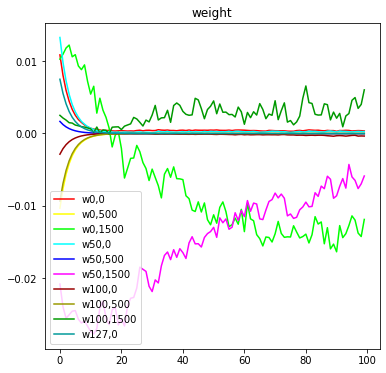

In [15]:
plt.figure(figsize=(6,6))
#A list for specifying the color of the graph. Changes are required according to the number of weights to be displayed.
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff','#ff00ff', '#990000', '#999900', '#009900', '#009999']

train_weight = train_weight.transpose(1,0)
for i in range(weight_num):
  plt.plot(range(epoch), train_weight[i], c=c[i])
plt.legend(['w0,0', 'w0,500', 'w0,1500', 'w50,0', 'w50,500', 'w50,1500', 'w100,0', 'w100,500', 'w100,1500', 'w127,0'])
plt.title('weight')
plt.show()

In [16]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Network()
net.cuda()


optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

In [17]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]




#define batch-size and epoch.
epoch=100
batchsize=100


inputc_num = np.array([0,0,0])
outputc_num = np.array([0,16,31])

weight_num = int(len(inputc_num))
k_size = int(net.conv1.weight.cpu().detach().numpy().shape[2])

train_weight = np.zeros((weight_num, epoch, k_size*k_size))

for epoch in range(1, epoch+1):
  print('epoch', epoch)
  perm = np.random.permutation(datasize)
  for i in range(0, datasize, batchsize):
    #Create mini-batch.
    x_batch = x_train[perm[i:i+batchsize]]
    y_batch = y_train[perm[i:i+batchsize]]
    
    #Convert a numpy array to a tensor to do gradient calculations.
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    
    #Initialize the stored gradient.
    optimizer.zero_grad()
    
    #Get the model output for the input mini-batch.
    y = net(x_batch)
    
    #Calculate loss from the output of the model. At this time, the activation function of the output layer is also reflected in the calculation.
    loss = softmax_cross_entropy(y, y_batch)  
    
    #From loss, calculate the gradient of each parameter.
    loss.backward()               
    
    #Each parameter is updated from the calculated gradient.
    optimizer.step()
  
  weight = net.conv1.weight.cpu().detach().numpy()
  
  for i in range(weight_num):
    weight0 = weight[outputc_num[i]][inputc_num[i]]
    weight0 = weight0.flatten()
    train_weight[i][epoch-1] = weight0


  sum_score = 0
  sum_loss = 0
  
  #Evaluate the model with train data.
  for i in range(0, datasize, batchsize):
    x_batch = x_train[i:i+batchsize]
    y_batch = y_train[i:i+batchsize]
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("train  mean loss={}, accuracy={}".format(sum_loss / datasize, sum_score / datasize))
  train_loss.append(sum_loss / datasize)
  train_acc.append(sum_score / datasize)


  sum_score = 0
  sum_loss = 0

  
  #Evaluate the model with test data.
  for i in range(0, datasize_test, batchsize):
    x_batch = x_test[i:i+batchsize]
    y_batch = y_test[i:i+batchsize]
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("test  mean loss={}, accuracy={}".format(sum_loss / datasize_test, sum_score / datasize_test))
  test_loss.append(sum_loss / datasize_test)
  test_acc.append(sum_score / datasize_test)


epoch 1
train  mean loss=0.13442462902205685, accuracy=0.9593
test  mean loss=0.12990378272719683, accuracy=0.9592
epoch 2
train  mean loss=0.09868242235078166, accuracy=0.9696
test  mean loss=0.09056047273566946, accuracy=0.972
epoch 3
train  mean loss=0.08135606101170803, accuracy=0.9763666666666667
test  mean loss=0.0769041426712647, accuracy=0.9754
epoch 4
train  mean loss=0.07061371055121222, accuracy=0.9810166666666666
test  mean loss=0.067748461086303, accuracy=0.9803
epoch 5
train  mean loss=0.06824241024907679, accuracy=0.97985
test  mean loss=0.065177435381338, accuracy=0.9797
epoch 6
train  mean loss=0.05956932508541892, accuracy=0.9837333333333333
test  mean loss=0.061234426867449655, accuracy=0.9811
epoch 7
train  mean loss=0.06713723675115034, accuracy=0.98205
test  mean loss=0.06502777030458674, accuracy=0.9807
epoch 8
train  mean loss=0.06074637556526189, accuracy=0.9829666666666667
test  mean loss=0.06049835636629723, accuracy=0.9831
epoch 9
train  mean loss=0.08014149

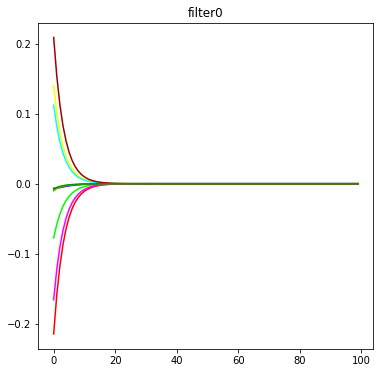

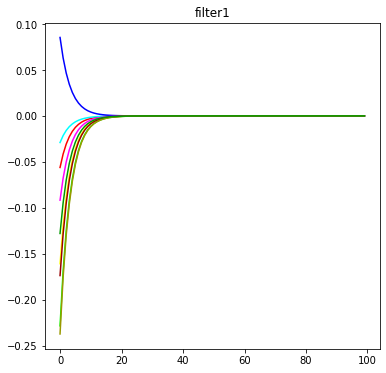

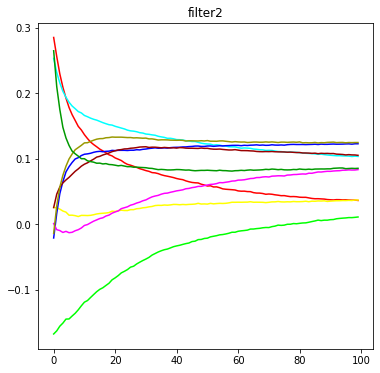

In [18]:
#A list for specifying the color of the graph. Changes are required according to the number of weights to be displayed.
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff','#ff00ff', '#990000', '#999900', '#009900', '#009999']

for i in range(weight_num):
  plt.figure(figsize=(6,6))
  p = train_weight[i]
  p = p.transpose(1,0)
  for j in range(k_size*k_size):
    plt.plot(range(epoch), p[j], c=c[j])
  plt.title('filter%d'%i)
  plt.show()

In [19]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Network()
net.cuda()


optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

In [20]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]



#define batch-size and epoch.
epoch=100
batchsize=100


inputc_num = np.array([0,16,28])
outputc_num = np.array([0,16,25])

weight_num = int(len(inputc_num))
k_size = int(net.conv2.weight.cpu().detach().numpy().shape[2])

train_weight = np.zeros((weight_num, epoch, k_size*k_size))

for epoch in range(1, epoch+1):
  print('epoch', epoch)
  perm = np.random.permutation(datasize)
  for i in range(0, datasize, batchsize):
    #Create mini-batch.
    x_batch = x_train[perm[i:i+batchsize]]
    y_batch = y_train[perm[i:i+batchsize]]
    
    #Convert a numpy array to a tensor to do gradient calculations.
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    
    #Initialize the stored gradient.
    optimizer.zero_grad()
    
    #Get the model output for the input mini-batch.
    y = net(x_batch)
    
    #Calculate loss from the output of the model. At this time, the activation function of the output layer is also reflected in the calculation.
    loss = softmax_cross_entropy(y, y_batch)  
    
    #From loss, calculate the gradient of each parameter.
    loss.backward()               
    
    #Each parameter is updated from the calculated gradient.
    optimizer.step()
  
  weight = net.conv2.weight.cpu().detach().numpy()
  
  for i in range(weight_num):
    weight0 = weight[outputc_num[i]][inputc_num[i]]
    weight0 = weight0.flatten()
    train_weight[i][epoch-1] = weight0


  sum_score = 0
  sum_loss = 0
  
  #Evaluate the model with train data.
  for i in range(0, datasize, batchsize):
    x_batch = x_train[i:i+batchsize]
    y_batch = y_train[i:i+batchsize]
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("train  mean loss={}, accuracy={}".format(sum_loss / datasize, sum_score / datasize))
  train_loss.append(sum_loss / datasize)
  train_acc.append(sum_score / datasize)


  sum_score = 0
  sum_loss = 0

  
  #Evaluate the model with test data.
  for i in range(0, datasize_test, batchsize):
    x_batch = x_test[i:i+batchsize]
    y_batch = y_test[i:i+batchsize]
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("test  mean loss={}, accuracy={}".format(sum_loss / datasize_test, sum_score / datasize_test))
  test_loss.append(sum_loss / datasize_test)
  test_acc.append(sum_score / datasize_test)


epoch 1
train  mean loss=0.1351410024302701, accuracy=0.9605833333333333
test  mean loss=0.12105748274363577, accuracy=0.9621
epoch 2
train  mean loss=0.08631505443869779, accuracy=0.9759166666666667
test  mean loss=0.079615747788921, accuracy=0.9757
epoch 3
train  mean loss=0.08022478008642793, accuracy=0.97655
test  mean loss=0.0738563608750701, accuracy=0.9772
epoch 4
train  mean loss=0.06401236934432139, accuracy=0.9816
test  mean loss=0.06090555534232408, accuracy=0.9812
epoch 5
train  mean loss=0.061974289975284286, accuracy=0.9833833333333334
test  mean loss=0.06121997920447029, accuracy=0.9819
epoch 6
train  mean loss=0.05983911020370821, accuracy=0.98315
test  mean loss=0.057375521148787814, accuracy=0.9831
epoch 7
train  mean loss=0.06741311596861731, accuracy=0.9805833333333334
test  mean loss=0.06298048625467345, accuracy=0.9824
epoch 8
train  mean loss=0.06421104732047146, accuracy=0.9817833333333333
test  mean loss=0.06375854477402754, accuracy=0.9811
epoch 9
train  mean 

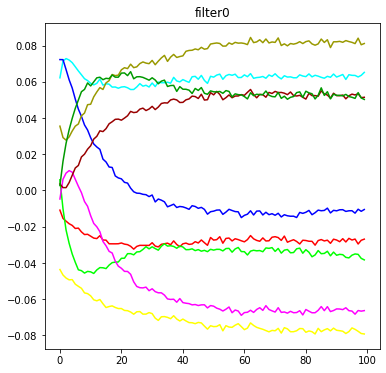

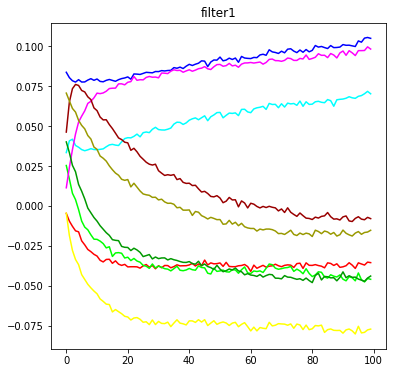

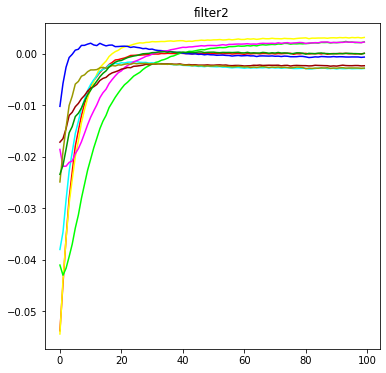

In [21]:
#A list for specifying the color of the graph. Changes are required according to the number of weights to be displayed.
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff','#ff00ff', '#990000', '#999900', '#009900', '#009999']

for i in range(weight_num):
  plt.figure(figsize=(6,6))
  p = train_weight[i]
  p = p.transpose(1,0)
  for j in range(k_size*k_size):
    plt.plot(range(epoch), p[j], c=c[j])
  plt.title('filter%d'%i)
  plt.show()

In [22]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Network()
net.cuda()


optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

In [23]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]



#define batch-size and epoch.
epoch=100
batchsize=100


for epoch in range(1, epoch+1):
  print('epoch', epoch)
  perm = np.random.permutation(datasize)
  for i in range(0, datasize, batchsize):
    #Create mini-batch.
    x_batch = x_train[perm[i:i+batchsize]]
    y_batch = y_train[perm[i:i+batchsize]]
    
    #Convert a numpy array to a tensor to do gradient calculations.
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    
    #Initialize the stored gradient.
    optimizer.zero_grad()
    
    #Get the model output for the input mini-batch.
    y = net(x_batch)
    
    #Calculate loss from the output of the model. At this time, the activation function of the output layer is also reflected in the calculation.
    loss = softmax_cross_entropy(y, y_batch)  
    
    #From loss, calculate the gradient of each parameter.
    loss.backward()               
    
    #Each parameter is updated from the calculated gradient.
    optimizer.step()


  sum_score = 0
  sum_loss = 0
  
  #Evaluate the model with train data.
  for i in range(0, datasize, batchsize):
    x_batch = x_train[i:i+batchsize]
    y_batch = y_train[i:i+batchsize]
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("train  mean loss={}, accuracy={}".format(sum_loss / datasize, sum_score / datasize))
  train_loss.append(sum_loss / datasize)
  train_acc.append(sum_score / datasize)


  sum_score = 0
  sum_loss = 0

  
  #Evaluate the model with test data.
  for i in range(0, datasize_test, batchsize):
    x_batch = x_test[i:i+batchsize]
    y_batch = y_test[i:i+batchsize]
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("test  mean loss={}, accuracy={}".format(sum_loss / datasize_test, sum_score / datasize_test))
  test_loss.append(sum_loss / datasize_test)
  test_acc.append(sum_score / datasize_test)
  
  
  

result = np.zeros((datasize, 32, 28, 28))

for i in range(0, datasize, batchsize):
  x_batch = x_train[i:i+batchsize]
  x_batch = torch.from_numpy(x_batch).float().cuda()
  fmap = net.conv1(x_batch)
  result[i:i+batchsize] = fmap
  
  

for i in range(10):
	pic = result[i]
	#pic=pic.transpose(1,2,0)
	#print(pic.shape)
	pic= pic.reshape((28,28))
	io.imsave("./imgtrain%d.png"%i, pic)


for i in range(10):
	pic = result_test[i]
	#pic=pic.transpose(1,2,0)
	#print(pic.shape)
	pic= pic.reshape((28,28))
	io.imsave("./imgtest%d.png"%i, pic)


epoch 1
train  mean loss=0.1347830182608838, accuracy=0.95995
test  mean loss=0.1208323350129649, accuracy=0.9623
epoch 2
train  mean loss=0.1023964602407068, accuracy=0.9691166666666666
test  mean loss=0.09528925652848556, accuracy=0.9701
epoch 3
train  mean loss=0.0681229147951429, accuracy=0.9818333333333333
test  mean loss=0.06300068892887793, accuracy=0.9817
epoch 4
train  mean loss=0.06770227944633612, accuracy=0.9806833333333334
test  mean loss=0.06339104440994561, accuracy=0.9821
epoch 5
train  mean loss=0.06480113281480347, accuracy=0.9811666666666666
test  mean loss=0.06023029829142615, accuracy=0.9817
epoch 6
train  mean loss=0.06682467170447733, accuracy=0.9806666666666667
test  mean loss=0.06353545143501833, accuracy=0.9798
epoch 7
train  mean loss=0.059450630977905046, accuracy=0.9832833333333333
test  mean loss=0.05485555027727969, accuracy=0.9842
epoch 8
train  mean loss=0.05757583685219288, accuracy=0.98415
test  mean loss=0.05469352137413807, accuracy=0.9847
epoch 9
t

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.